In [ ]:
!pip install opencv-python tqdm


In [1]:
import cv2
import os
import glob
from tqdm import tqdm

# ================= CONFIGURATION =================
# Point this to the folder containing '01', '02', etc.
# Based on your screenshot, it ends in 'testing_videos'
dataset_root = r"/kaggle/working/cleaned_testing_videos"

# Where to save the output MP4 files
output_folder = "rendered_videos"

# Frame rate (Frames Per Second). 
# 25 or 30 is standard. Lower it (e.g., 10) if the video feels too fast.
fps = 25 
# =================================================

def create_video_from_frames(video_folder_path, output_path, fps):
    # 1. Find all images (jpg, png, jpeg)
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        images.extend(glob.glob(os.path.join(video_folder_path, ext)))
    
    if not images:
        print(f"No images found in {video_folder_path}")
        return

    # 2. Sort them numerically! 
    # Standard sort usually fails on "frame_1" vs "frame_10", 
    # but your data has padding (0093), so standard sort usually works.
    # We use a lambda just to be safe.
    try:
        images.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    except:
        images.sort() # Fallback if naming convention is different

    # 3. Read the first frame to get dimensions
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape
    size = (width, height)

    # 4. Initialize VideoWriter
    # 'mp4v' is a standard codec for .mp4
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    # 5. Write frames
    video_name = os.path.basename(output_path)
    for image_path in tqdm(images, desc=f"Rendering {video_name}", unit="frame"):
        img = cv2.imread(image_path)
        out.write(img)

    out.release()
    print(f"Saved: {output_path}")

def main():
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get list of video directories (01, 02, etc.)
    # We assume directories inside 'testing_videos' are the video clips
    video_dirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
    video_dirs.sort()

    print(f"Found {len(video_dirs)} video folders. Starting conversion...")

    for video_dir in video_dirs:
        full_path = os.path.join(dataset_root, video_dir)
        save_path = os.path.join(output_folder, f"video_{video_dir}.mp4")
        
        create_video_from_frames(full_path, save_path, fps)

    print("\nDone! Check the 'rendered_videos' folder.")

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/cleaned_testing_videos'

In [2]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torchvision.transforms.functional as TF

# ================= CONFIGURATION =================
# POINT THIS TO YOUR *PERFECT* TRAINING DATA FOLDER
# Example: '/kaggle/input/avenue-dataset/training_videos'
TRAIN_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos' 

MODEL_SAVE_PATH = 'rotnet_model.pth'
BATCH_SIZE = 32
EPOCHS = 6      # It learns very fast, 3 is usually enough
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

class RotationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom Dataset that creates synthetic training data.
        It takes perfect images and randomly flips them to create 'bad' examples.
        """
        self.transform = transform
        self.image_paths = []
        
        # Recursively find all images in the training folder
        # Adjust extension if your images are .png
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '**', '*.jpg'), recursive=True))
        
        if len(self.image_paths) == 0:
            print(f"WARNING: No images found in {root_dir}. Check your path!")
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # --- SELF-SUPERVISED LOGIC ---
        # 0 = Upright (Original)
        # 1 = Flipped (Rotated 180)
        label = random.choice([0, 1])
        
        if label == 1:
            # Rotate image 180 degrees
            image = image.transpose(Image.FLIP_TOP_BOTTOM)            
        # Apply standard transforms (Resize, Tensorize, Normalize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

def train_rotnet():
    print(f"Using Device: {DEVICE}")
    
    # 1. Define Transforms (Standard ResNet sizing)
    # Note: We do NOT use random rotation augmentation here, as that would confuse the labels.
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 2. Prepare Data
    full_dataset = RotationDataset(TRAIN_DATA_DIR, transform=transform)
    print(f"Total Frames Found: {len(full_dataset)}")
    
    # Split: 80% Train, 20% Validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # 3. Setup Model (ResNet18)
    model = models.resnet18(pretrained=True)
    
    # Modify the final layer for Binary Classification (2 classes: 0 or 1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    
    model = model.to(DEVICE)
    
    # 4. Optimizer & Loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # 5. Training Loop
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_acc = 100 * correct / total
        print(f"Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        print(f"Val Acc:   {val_acc:.2f}%")

    # 6. Save Model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nModel saved to {MODEL_SAVE_PATH}")
    print("Step 1 Complete. Ready for cleaning.")

if __name__ == "__main__":
    train_rotnet()

Using Device: cuda
Total Frames Found: 9204
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]



Epoch 1/6
--------------------


KeyboardInterrupt: 

In [3]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/input/flipercorrectorvlg/pytorch/default/1/rotnet_model(1).pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

Processing on: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found 11706 frames to process.


Cleaning: 100%|██████████| 11706/11706 [03:22<00:00, 57.91it/s]

------------------------------
Cleaning Complete!
Total Images: 11706
Images Flipped/Fixed: 1195
Cleaned dataset saved to: /kaggle/working/cleaned_testing_videos


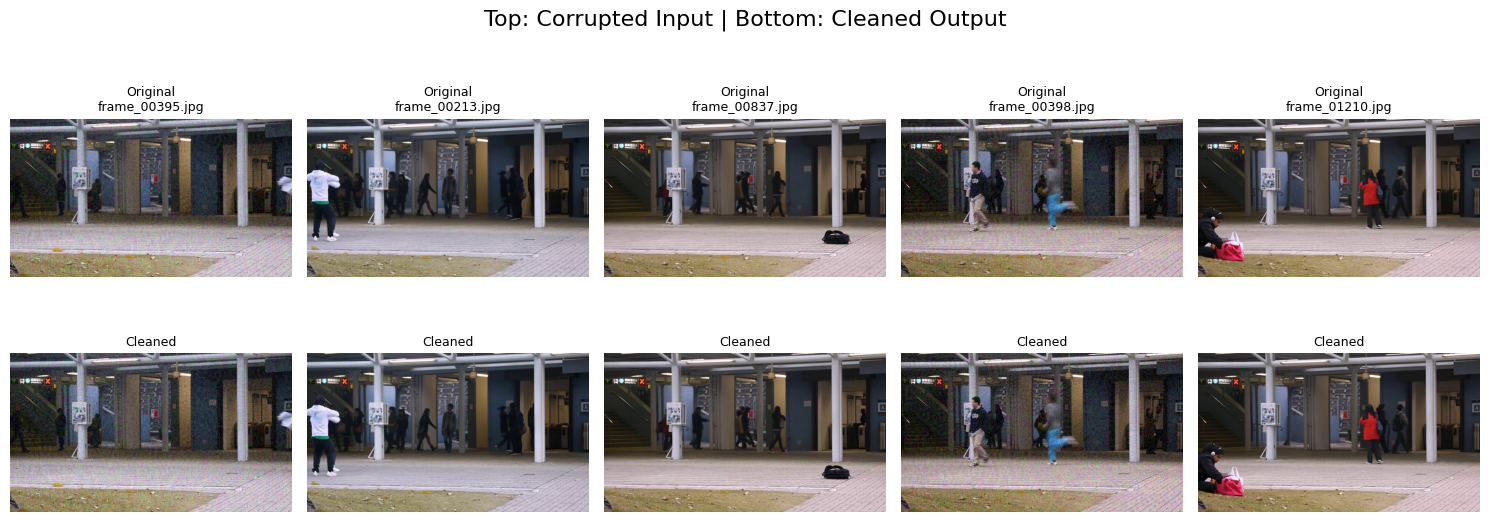

In [3]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

# ================= CONFIGURATION =================
# 1. The Original "Bad" Folder
CORRUPTED_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# 2. The New "Fixed" Folder (From Step 2)
CLEANED_DIR = '/kaggle/working/cleaned_testing_videos'

# How many examples to check
NUM_SAMPLES = 5
# =================================================

def visualize_results():
    # 1. Get list of all files in the corrupted dir
    # Use glob to find recursive paths (e.g., "01/frame.jpg")
    all_files = glob.glob(os.path.join(CORRUPTED_DIR, '**', '*.jpg'), recursive=True)
    
    if len(all_files) == 0:
        print("Error: No files found. Check your paths!")
        return

    # 2. Pick random samples
    samples = random.sample(all_files, NUM_SAMPLES)
    
    # 3. Setup Plot
    fig, axes = plt.subplots(2, NUM_SAMPLES, figsize=(15, 6))
    plt.suptitle("Top: Corrupted Input | Bottom: Cleaned Output", fontsize=16)
    
    for i, file_path in enumerate(samples):
        # A. Get the Relative Path (e.g., "01/frame_001.jpg") to find the matching pair
        rel_path = os.path.relpath(file_path, CORRUPTED_DIR)
        clean_path = os.path.join(CLEANED_DIR, rel_path)
        
        # B. Load Images
        img_bad = Image.open(file_path).convert('RGB')
        
        if os.path.exists(clean_path):
            img_good = Image.open(clean_path).convert('RGB')
        else:
            print(f"Warning: Cleaned version not found for {rel_path}")
            img_good = Image.new('RGB', (224, 224), color='red') # Error placeholder

        # C. Plot "Before"
        axes[0, i].imshow(img_bad)
        axes[0, i].set_title(f"Original\n{os.path.basename(rel_path)}", fontsize=9)
        axes[0, i].axis('off')
        
        # D. Plot "After"
        axes[1, i].imshow(img_good)
        axes[1, i].set_title(f"Cleaned", fontsize=9)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_results()

In [4]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
TRAIN_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
MODEL_SAVE_PATH = 'st_autoencoder_rgb.pth'
BATCH_SIZE = 16
EPOCHS = 15 # RGB learns fast. 10-15 is usually enough.
CLIP_LEN = 16
IMG_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

class VideoClipDataset(Dataset):
    def __init__(self, root_dir, transform=None, clip_length=16):
        self.clips = []
        self.transform = transform
        video_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])
        for vid in video_folders:
            vid_path = os.path.join(root_dir, vid)
            frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
            if len(frames) < 2 * clip_length: continue
            # Stride 2 to train faster
            for i in range(0, len(frames) - (2 * clip_length) + 1, 2): 
                input_paths = frames[i : i + clip_length]
                target_paths = frames[i + clip_length : i + (2 * clip_length)]
                self.clips.append((input_paths, target_paths))
    def __len__(self): return len(self.clips)
    def __getitem__(self, idx):
        input_paths, target_paths = self.clips[idx]
        def load_vol(paths):
            vol = [Image.open(p).convert('RGB') for p in paths]
            if self.transform: vol = [self.transform(img) for img in vol]
            return torch.stack(vol, dim=0).permute(1, 0, 2, 3)
        return load_vol(input_paths), load_vol(target_paths)

class STAutoEncoder_Full(nn.Module):
    def __init__(self, in_channels=3): 
        super(STAutoEncoder_Full, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32); self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 48, 3, padding=1); self.bn2 = nn.BatchNorm3d(48); self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = nn.Conv3d(48, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64); self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = nn.Conv3d(64, 64, 3, padding=1); self.bn4 = nn.BatchNorm3d(64); self.relu = nn.LeakyReLU(0.1)
        self.rec_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.rec_bn1 = nn.BatchNorm3d(48)
        self.rec_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.rec_bn2 = nn.BatchNorm3d(32)
        self.rec_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.rec_bn3 = nn.BatchNorm3d(32)
        self.rec_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.pred_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.pred_bn1 = nn.BatchNorm3d(48)
        self.pred_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.pred_bn2 = nn.BatchNorm3d(32)
        self.pred_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.pred_bn3 = nn.BatchNorm3d(32)
        self.pred_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        l = self.relu(self.bn4(self.conv4(self.pool3(self.relu(self.bn3(self.conv3(self.pool2(self.relu(self.bn2(self.conv2(self.pool1(self.relu(self.bn1(self.conv1(x)))))))))))))))
        r = self.sigmoid(self.rec_final(self.relu(self.rec_bn3(self.rec_deconv3(self.relu(self.rec_bn2(self.rec_deconv2(self.relu(self.rec_bn1(self.rec_deconv1(l)))))))))))
        p = self.sigmoid(self.pred_final(self.relu(self.pred_bn3(self.pred_deconv3(self.relu(self.pred_bn2(self.pred_deconv2(self.relu(self.pred_bn1(self.pred_deconv1(l)))))))))))
        return r, p

class WeightedPredictionLoss(nn.Module):
    def __init__(self, clip_length=16):
        super(WeightedPredictionLoss, self).__init__()
        self.clip_length = clip_length
        self.mse = nn.MSELoss(reduction='none')
    def forward(self, prediction, target):
        loss = self.mse(prediction, target) 
        frame_losses = loss.mean(dim=[1, 3, 4]) 
        weights = torch.arange(self.clip_length, 0, -1).float().to(prediction.device).view(1, -1)
        return (frame_losses * weights).mean()

def train_rgb():
    print(f"Training RGB Model on {DEVICE}...")
    transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
    dataset = VideoClipDataset(TRAIN_DIR, transform=transform, clip_length=CLIP_LEN)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    
    model = STAutoEncoder_Full(in_channels=3)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    crit_rec = nn.MSELoss(); crit_pred = WeightedPredictionLoss(CLIP_LEN)
    
    try:
        for epoch in range(EPOCHS):
            model.train()
            loop = tqdm(loader, desc=f"Ep {epoch+1}/{EPOCHS}")
            for inp, tgt in loop:
                inp, tgt = inp.to(DEVICE), tgt.to(DEVICE)
                optimizer.zero_grad()
                rec, pred = model(inp)
                loss = crit_rec(rec, inp) + crit_pred(pred, tgt)
                loss.backward()
                optimizer.step()
                loop.set_postfix(loss=loss.item())
            if (epoch+1) % 5 == 0: torch.save(model.module.state_dict() if hasattr(model,'module') else model.state_dict(), f"stae_rgb_ep{epoch+1}.pth")
    except KeyboardInterrupt: print("Interrupted. Saving...")
    torch.save(model.module.state_dict() if hasattr(model,'module') else model.state_dict(), MODEL_SAVE_PATH)
    print("Training Done.")

if __name__ == "__main__":
    train_rgb()

Training RGB Model on cuda...


Ep 15/15: 100%|██████████| 273/273 [04:13<00:00,  1.08it/s, loss=0.0168] 

Training Done.


Preparing RGB Visualization...
Selected Video: 16
Processing 740 frames...
Plot saved to rgb_anomaly_plot_16.png


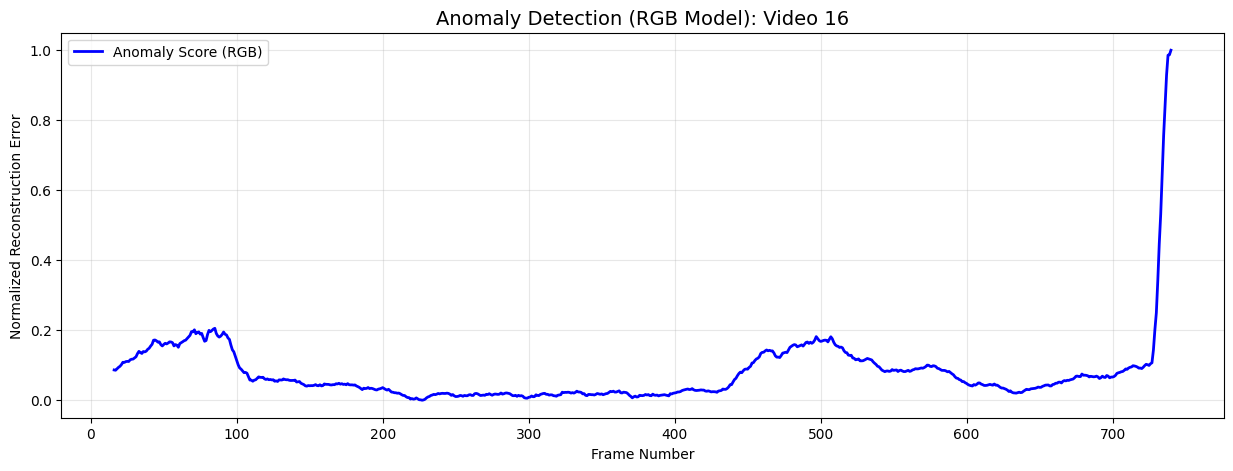

In [6]:
import os
import glob
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS (from Step 1)
CLEAN_TEST_DIR = '/kaggle/working/cleaned_testing_videos'

# 2. Path to Trained RGB Model
MODEL_PATH = 'st_autoencoder_rgb.pth'

CLIP_LEN = 16
IMG_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. Model Architecture (Must match training) ---
class STAutoEncoder_Full(nn.Module):
    def __init__(self, in_channels=3): 
        super(STAutoEncoder_Full, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32); self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 48, 3, padding=1); self.bn2 = nn.BatchNorm3d(48); self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = nn.Conv3d(48, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64); self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = nn.Conv3d(64, 64, 3, padding=1); self.bn4 = nn.BatchNorm3d(64); self.relu = nn.LeakyReLU(0.1)
        
        self.rec_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.rec_bn1 = nn.BatchNorm3d(48)
        self.rec_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.rec_bn2 = nn.BatchNorm3d(32)
        self.rec_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.rec_bn3 = nn.BatchNorm3d(32)
        self.rec_final = nn.Conv3d(32, in_channels, 3, padding=1)
        
        self.pred_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.pred_bn1 = nn.BatchNorm3d(48)
        self.pred_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.pred_bn2 = nn.BatchNorm3d(32)
        self.pred_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.pred_bn3 = nn.BatchNorm3d(32)
        self.pred_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        l = self.relu(self.bn4(self.conv4(self.pool3(self.relu(self.bn3(self.conv3(self.pool2(self.relu(self.bn2(self.conv2(self.pool1(self.relu(self.bn1(self.conv1(x)))))))))))))))
        r = self.sigmoid(self.rec_final(self.relu(self.rec_bn3(self.rec_deconv3(self.relu(self.rec_bn2(self.rec_deconv2(self.relu(self.rec_bn1(self.rec_deconv1(l)))))))))))
        p = self.sigmoid(self.pred_final(self.relu(self.pred_bn3(self.pred_deconv3(self.relu(self.pred_bn2(self.pred_deconv2(self.relu(self.pred_bn1(self.pred_deconv1(l)))))))))))
        return r, p

def visualize_rgb_anomaly():
    print("Preparing RGB Visualization...")
    
    # 1. Pick a Random Video
    video_folders = sorted([f for f in os.listdir(CLEAN_TEST_DIR) if os.path.isdir(os.path.join(CLEAN_TEST_DIR, f))])
    if not video_folders:
        print("No video folders found! Did you run the cleaner?")
        return
        
    random_vid_id = random.choice(video_folders)
    print(f"Selected Video: {random_vid_id}")
    
    vid_path = os.path.join(CLEAN_TEST_DIR, random_vid_id)
    frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
    
    if len(frames) < CLIP_LEN:
        print("Video too short!")
        return

    # 2. Load Model
    model = STAutoEncoder_Full(in_channels=3)
    
    # Load weights
    if not os.path.exists(MODEL_PATH):
        print(f"Model file {MODEL_PATH} not found!")
        return
        
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'): new_state_dict[k[7:]] = v
        else: new_state_dict[k] = v
    model.load_state_dict(new_state_dict)
    model.to(DEVICE)
    model.eval()
    
    # 3. Process Video
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])
    
    scores = []
    frame_indices = []
    mse_loss = nn.MSELoss(reduction='none')
    
    print(f"Processing {len(frames)} frames...")
    
    with torch.no_grad():
        # Slide through video
        for i in range(len(frames) - CLIP_LEN + 1):
            clip_paths = frames[i : i + CLIP_LEN]
            
            # Load RGB frames
            volume = [transform(Image.open(p).convert('RGB')) for p in clip_paths]
            
            # Stack: (1, 3, 16, 128, 128)
            input_tensor = torch.stack(volume, dim=0).permute(1, 0, 2, 3).unsqueeze(0).to(DEVICE)
            
            # Inference
            rec_out, _ = model(input_tensor)
            
            # Calculate Error
            loss = mse_loss(rec_out, input_tensor)
            error_val = torch.sum(loss).item()
            
            scores.append(error_val)
            # Map score to the last frame of the clip
            frame_indices.append(i + CLIP_LEN)

    # 4. Plot
    scores = np.array(scores)
    
    # Normalize scores 0-1 for plotting
    if scores.max() > scores.min():
        scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
    else:
        scores_norm = scores
        
    plt.figure(figsize=(15, 5))
    plt.plot(frame_indices, scores_norm, color='blue', linewidth=2, label='Anomaly Score (RGB)')
    plt.title(f"Anomaly Detection (RGB Model): Video {random_vid_id}", fontsize=14)
    plt.xlabel("Frame Number")
    plt.ylabel("Normalized Reconstruction Error")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    save_path = f"rgb_anomaly_plot_{random_vid_id}.png"
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")
    plt.show()

if __name__ == "__main__":
    visualize_rgb_anomaly()

In [8]:
import os
import glob
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
CLEAN_TEST_DIR = '/kaggle/working/cleaned_testing_videos' 
MODEL_PATH = 'st_autoencoder_rgb.pth'
OUTPUT_CSV = 'submission_smart_fill.csv'

CLIP_LEN = 16
IMG_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. Model Architecture ---
class STAutoEncoder_Full(nn.Module):
    def __init__(self, in_channels=3): 
        super(STAutoEncoder_Full, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32); self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 48, 3, padding=1); self.bn2 = nn.BatchNorm3d(48); self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = nn.Conv3d(48, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64); self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = nn.Conv3d(64, 64, 3, padding=1); self.bn4 = nn.BatchNorm3d(64); self.relu = nn.LeakyReLU(0.1)
        self.rec_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.rec_bn1 = nn.BatchNorm3d(48)
        self.rec_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.rec_bn2 = nn.BatchNorm3d(32)
        self.rec_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.rec_bn3 = nn.BatchNorm3d(32)
        self.rec_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.pred_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.pred_bn1 = nn.BatchNorm3d(48)
        self.pred_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.pred_bn2 = nn.BatchNorm3d(32)
        self.pred_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.pred_bn3 = nn.BatchNorm3d(32)
        self.pred_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        l = self.relu(self.bn4(self.conv4(self.pool3(self.relu(self.bn3(self.conv3(self.pool2(self.relu(self.bn2(self.conv2(self.pool1(self.relu(self.bn1(self.conv1(x)))))))))))))))
        r = self.sigmoid(self.rec_final(self.relu(self.rec_bn3(self.rec_deconv3(self.relu(self.rec_bn2(self.rec_deconv2(self.relu(self.rec_bn1(self.rec_deconv1(l)))))))))))
        p = self.sigmoid(self.pred_final(self.relu(self.pred_bn3(self.pred_deconv3(self.relu(self.pred_bn2(self.pred_deconv2(self.relu(self.pred_bn1(self.pred_deconv1(l)))))))))))
        return r, p

# --- 2. Dataset ---
class TestRGBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for vid in sorted(os.listdir(root_dir)):
            v_path = os.path.join(root_dir, vid)
            if not os.path.isdir(v_path): continue
            frames = sorted(glob.glob(os.path.join(v_path, '*.jpg')))
            # Sliding Window of 1
            for i in range(len(frames) - CLIP_LEN + 1):
                clip = frames[i : i + CLIP_LEN]
                target_fname = os.path.basename(clip[-1])
                f_num = int(target_fname.split('_')[-1].split('.')[0])
                target_id = f"{int(vid)}_{f_num}"
                self.samples.append((clip, target_id))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        clip, row_id = self.samples[idx]
        vol = [self.transform(Image.open(p).convert('RGB')) for p in clip]
        return torch.stack(vol, dim=0).permute(1, 0, 2, 3), row_id

# --- 3. Smart Fill Function ---
def smart_fill_missing(group):
    # Sort by frame number to be safe
    group = group.sort_values('frame')
    scores = group['Score'].values.astype(float) # Ensure float for NaNs
    
    # Check for NaNs
    if np.isnan(scores).all(): return group # Should not happen if video has data
    
    valid_indices = np.where(~np.isnan(scores))[0]
    first_valid = valid_indices[0]
    last_valid = valid_indices[-1]
    
    # 1. Fill Start (Leading NaNs)
    if first_valid > 0:
        # Take up to 32 frames after the gap
        window_end = min(first_valid + 32, len(scores))
        avg_start = np.nanmean(scores[first_valid:window_end])
        scores[:first_valid] = avg_start
        
    # 2. Fill End (Trailing NaNs)
    if last_valid < len(scores) - 1:
        # Take up to 32 frames before the gap
        window_start = max(0, last_valid - 32 + 1)
        avg_end = np.nanmean(scores[window_start : last_valid + 1])
        scores[last_valid + 1:] = avg_end
        
    group['Score'] = scores
    return group

def generate_rgb_submission():
    print(f"Generating Submission (Smart Fill) on {DEVICE}")
    
    # 1. Master List
    print("Scanning for all expected frames...")
    all_expected_ids = []
    for vid in sorted(os.listdir(CLEAN_TEST_DIR)):
        v_path = os.path.join(CLEAN_TEST_DIR, vid)
        if not os.path.isdir(v_path): continue
        for f in glob.glob(os.path.join(v_path, '*.jpg')):
            try:
                vid_id = int(vid)
                f_num = int(os.path.basename(f).split('_')[-1].split('.')[0])
                all_expected_ids.append(f"{vid_id}_{f_num}")
            except: pass
    master_df = pd.DataFrame(all_expected_ids, columns=['Id'])
    
    # 2. Inference
    transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
    dataset = TestRGBDataset(CLEAN_TEST_DIR, transform=transform)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    
    model = STAutoEncoder_Full(3).to(DEVICE)
    if os.path.exists(MODEL_PATH):
        st = torch.load(MODEL_PATH, map_location=DEVICE)
        new_st = {k[7:] if k.startswith('module.') else k: v for k,v in st.items()}
        model.load_state_dict(new_st)
    else:
        print(f"Model {MODEL_PATH} not found."); return

    model.eval()
    mse = nn.MSELoss(reduction='none')
    results = []

    print("Running Inference...")
    with torch.no_grad():
        for volume, row_id in tqdm(loader):
            volume = volume.to(DEVICE)
            rec_out, _ = model(volume)
            loss = mse(rec_out, volume)
            score = torch.sum(loss).item()
            results.append({'Id': row_id[0], 'Score': score})
            
    # 3. Smart Merge
    results_df = pd.DataFrame(results)
    final_df = pd.merge(master_df, results_df, on='Id', how='left')
    
    # Extract Vid/Frame for grouping
    final_df[['vid', 'frame']] = final_df['Id'].str.split('_', expand=True).astype(int)
    
    # Apply Smart Fill per Video
    print("Applying Smart Fill (Avg adjacent 32 frames)...")
    final_df = final_df.groupby('vid', group_keys=False).apply(smart_fill_missing)
    
    # Just in case any NaNs remain (e.g. video was shorter than window?), fill with global min
    final_df['Score'] = final_df['Score'].fillna(final_df['Score'].min())
    
    # Normalize
    max_s = final_df['Score'].max()
    min_s = final_df['Score'].min()
    final_df['Predicted'] = (final_df['Score'] - min_s) / (max_s - min_s)
    
    # Sort and Save
    final_df = final_df.sort_values(by=['vid', 'frame'])
    final_df[['Id', 'Predicted']].to_csv(OUTPUT_CSV, index=False)
    
    print(f"\nSUCCESS! Submission saved to {OUTPUT_CSV}")
    print(final_df.head(20)) # Check the first few rows to confirm they are NOT 0.0

if __name__ == "__main__":
    generate_rgb_submission()

Generating Submission (Smart Fill) on cuda
Scanning for all expected frames...
Running Inference...


100%|██████████| 11391/11391 [05:30<00:00, 34.42it/s]
/tmp/ipykernel_55/3845383079.py:149: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = final_df.groupby('vid', group_keys=False).apply(smart_fill_missing)


Applying Smart Fill (Avg adjacent 32 frames)...

SUCCESS! Submission saved to submission_smart_fill.csv
        Id         Score  vid  frame  Predicted
358  1_939   9288.324753    1    939   0.780684
83   1_940   9288.324753    1    940   0.780684
178  1_941   9288.324753    1    941   0.780684
135  1_942   9288.324753    1    942   0.780684
413  1_943   9288.324753    1    943   0.780684
58   1_944   9288.324753    1    944   0.780684
246  1_945   9288.324753    1    945   0.780684
56   1_946   9288.324753    1    946   0.780684
245  1_947   9288.324753    1    947   0.780684
342  1_948   9288.324753    1    948   0.780684
277  1_949   9288.324753    1    949   0.780684
323  1_950   9288.324753    1    950   0.780684
434  1_951   9288.324753    1    951   0.780684
407  1_952   9288.324753    1    952   0.780684
459  1_953   9288.324753    1    953   0.780684
260  1_954  10351.125000    1    954   0.877096
331  1_955  10649.775391    1    955   0.904189
467  1_956  10908.929688    1   